In [4]:
import collections
import sys

sys.path.append('../src')


In [6]:
import os

import foolbox.attacks as fa
from data import loader
from data import preprocess
from foolbox import PyTorchModel, accuracy
from skimage.metrics import peak_signal_noise_ratio as psnr  # 计算信噪比
from skimage.metrics import structural_similarity as ssim  # 计算图片平均结构相似度
import json
import time
import numpy as np
import torch
import torchvision
from torch.autograd import Variable
import random
import model

In [7]:
def load_dataset(path, is_train, is_shuffle, name, batch_size):
    """
    返回torch.utils.data.DataLoader对象
    :param path: 数据集所在路径
    :param is_train: 是否是训练数据集
    :param is_shuffle: 是否随机打乱
    :param name: 数据集名称
    :param batch_size: 批量大小
    :return: torch.utils.data.DataLoader
    """
    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=torchvision.transforms.Compose([
            preprocess.CenterCrop(88),
            torchvision.transforms.ToTensor()
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_shuffle, num_workers=1
    )
    return data_loader

In [8]:
def get_data_range(data_set):
    """
    获取数据范围
    :param data_set:
    :return: a tuple (min_value, max_value)
    """
    min_value, max_value = 0, 0
    for i, data in enumerate(data_set):
        images, labels, _ = data
        min_value = min(min_value, images.min().float().item())
        max_value = max(max_value, images.max().float().item())
    return min_value, max_value

In [9]:
# JS-MA 攻击算法
class JSMA(object):
    def __init__(self, epochs=500, device='cuda:0', theta=0.01, classes=10, target_label=None):
        self.epochs = epochs  # epochs 500
        self.classes = classes  # 类别数
        self.target_label = target_label  # 8
        self.device = device  # cuda:0
        self.theta = theta  # theta
        self.raw = None
        self.clipped = None
        self.success = None

    def __call__(self, net, images, labels, min_value, max_value, epsilons, *args, **kwargs):
        epochs = self.epochs  # epochs
        theta = self.theta  # 扰动系数
        target_label = self.target_label  # 攻击目标
        select_target = None
        if target_label:
            select_target = Variable(torch.Tensor([float(target_label)]).to(self.device).long())
        loss_func = torch.nn.CrossEntropyLoss()

        self.raw = images  # 原始图片
        self.clipped = images.clone()  # 原始图像
        self.success = [False for i in range(self.raw.shape[0])]  # 是否攻击成功

        for i, (img, ori_label) in enumerate(zip(self.clipped, labels)):
            img = torch.unsqueeze(img, dim=0)
            img.requires_grad = True
            target = 1
            if select_target is None:
                choose_list = [num for num in range(0, self.classes) if num != ori_label.item()]
                choice = random.choice(choose_list)
                target = Variable(torch.Tensor([float(choice)])).to(self.device).long()
            else:
                target = select_target
            mask = np.ones_like(img.data.cpu().numpy())  # 定义搜索域，修改后的位置置零
            # 定义边界
            for epoch in range(epochs):
                output = net(img)
                label = np.argmax(output.data.cpu().numpy())
                loss = loss_func(output, target)
                # print('epoch={} label={} loss={}'.format(epoch, label, loss))
                if target_label and label == target_label:
                    self.success[i] = True
                    break  # 攻击成功
                if target_label is None and label != ori_label.item():
                    self.success[i] = True
                    break  # 攻击成功
                JSMA.zero_gradients(img)  # 梯度清零
                idx, pix_sign = JSMA.saliency_map(output, img, target, mask)
                # print("idx = ", idx, "pix_sign = ", pix_sign)
                # 添加扰动
                img.data[idx] = img.data[idx] + pix_sign * theta * (max_value - min_value)
                # 达到极限的点不再参与更新
                if (img.data[idx] <= min_value) or (img.data[idx] >= max_value):
                    # print('idx={} over {}'.format(idx, img.data[idx]))
                    mask[idx] = 0
                    img.data.cpu()[idx] = np.clip(img.data.cpu()[idx], min_value, max_value)
            img.requires_grad = False
            img = torch.squeeze(img, dim=0)
        self.success = torch.tensor(self.success).to(self.device)  # to tensor to device
        return self.raw, self.clipped, self.success

    # Saliency map
    # 此方法为beta参数的简化版本，注重攻击目标贡献大的点
    @staticmethod
    def saliency_map(F, x, t, mask):
        # F 为模型的输出
        # t 为攻击的类别
        # x 表示输入的图像
        # mask 标记位，记录已经访问的点的坐标
        F[0, t].backward(retain_graph=True)
        derivative = x.grad.data.cpu().numpy().copy()
        alphas = derivative * mask  # 预测 对攻击目标的贡献
        betas = -np.ones_like(alphas)  # 预测对非攻击目标的贡献
        sal_map = np.abs(alphas) * np.abs(betas) * np.sign(alphas * betas)
        idx = np.argmin(sal_map)  # 最佳像素和扰动方向
        idx = np.unravel_index(idx, mask.shape)  # 转换成(p1,p2)格式
        pix_sign = np.sign(alphas)[idx]
        return idx, pix_sign

    # 梯度清0
    @staticmethod
    def zero_gradients(x):
        if isinstance(x, torch.Tensor):
            if x.grad is not None:
                x.grad.detach_()
                x.grad.zero_()
        elif isinstance(x, collections.abc.Iterable):
            for elem in x:
                JSMA.zero_gradients(elem)

In [10]:
def calculate_avg_norm_distortion_factor(raw_images, adv_images, is_success, data_range):
    """
        计算相应的指标
    """
    # 筛选出 真正的对抗样本
    select_raw_images = raw_images[is_success]
    select_adv_images = adv_images[is_success]

    # 没有对抗样本
    if select_raw_images.shape[0] == 0:
        return [0, 0, 0], 0, 0, [0, 0, 0]

    linf_avg_epsion = torch.norm(select_raw_images - select_adv_images, p=float('inf'), dim=(1, 2, 3))
    l1_avg_epsion = torch.norm(select_raw_images - select_adv_images, p=1, dim=(1, 2, 3))
    l2_avg_epsion = torch.norm(select_raw_images - select_adv_images, p=2, dim=(1, 2, 3))

    linf_distortion_factor = (linf_avg_epsion
                              / torch.norm(select_raw_images, p=float('inf'), dim=(1, 2, 3))).mean().item()
    l1_distortion_factor = (l1_avg_epsion
                            / torch.norm(select_raw_images, p=1, dim=(1, 2, 3))).mean().item()
    l2_distortion_factor = (l2_avg_epsion
                            / torch.norm(select_raw_images, p=2, dim=(1, 2, 3))).mean().item()

    psnr_item = psnr(select_raw_images.cpu().numpy(), select_adv_images.cpu().numpy(), data_range=data_range)

    # channel_last
    ssim_item = 0
    for index in range(select_raw_images.shape[0]):
        image_ndarray = np.array(raw_images[index].cpu())
        adv_ndarray = np.array(adv_images[index].cpu())
        ssim_item = ssim_item + ssim(image_ndarray, adv_ndarray, win_size=11, data_range=data_range, channel_axis=0)
    ssim_item /= select_raw_images.shape[0]

    # metric = dict()
    # metric["l1_distortion_factor"] = l1_distortion_factor
    # metric["l2_distortion_factor"] = l2_distortion_factor
    # metric["linf_distortion_factor"] = linf_distortion_factor
    # metric["psnr_item"] = psnr_item
    # metric["ssim_item"] = ssim_item
    # metric["l1_avg_epsion"] = l1_avg_epsion.mean().item()
    # metric["l2_avg_epsion"] = l2_avg_epsion.mean().item()
    # metric["linf_avg_epsion"] = linf_avg_epsion.mean().item()
    return [l1_distortion_factor, l2_distortion_factor, linf_distortion_factor], ssim_item, psnr_item, \
        [l1_avg_epsion.mean().item(), l2_avg_epsion.mean().item(), linf_avg_epsion.mean().item()]

In [11]:
best_path = '/guoxuan/AConvNet-pytorch-main/experiments/model/AConvNet-SOC/model-030.pth'

In [19]:
import sys
sys.path.append('../src')
import os

import foolbox as fa
import model
import torch
import torchvision
from data import loader
from data import preprocess
from foolbox import PyTorchModel, accuracy
from skimage.metrics import peak_signal_noise_ratio as psnr  # 计算信噪比
from utils import common
from skimage.metrics import structural_similarity as ssim  # 计算图片平均结构相似度
import json

In [20]:
config = common.load_config(os.path.join(common.project_root, 'experiments/config/AConvNet-SOC.json'))
model_name = config['model_name']


m = model.Model(
    classes=config['num_classes'], channels=config['channels'],
)

best_path = '/guoxuan/AConvNet-pytorch-main/experiments/model/AConvNet-SOC/model-030.pth'
test_set = load_dataset('dataset', False, True, 'soc', 100)

m.load(best_path)
m.net.eval()

load test data set: 0it [00:00, ?it/s]

load test data set: 2425it [00:00, 2544.85it/s]


Network(
  (_layer): Sequential(
    (0): Conv2DBlock(
      (_layer): Sequential(
        (conv): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1), padding=valid)
        (relu): ReLU(inplace=True)
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Conv2DBlock(
      (_layer): Sequential(
        (conv): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
        (relu): ReLU(inplace=True)
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Conv2DBlock(
      (_layer): Sequential(
        (conv): Conv2d(32, 64, kernel_size=(6, 6), stride=(1, 1), padding=valid)
        (relu): ReLU(inplace=True)
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): Conv2DBlock(
      (_layer): Sequential(
        (conv): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=valid)
        (re

In [21]:
min_value, max_value = get_data_range(test_set)

In [22]:
test_set = load_dataset('dataset', False, True, 'soc', 100)
images, labels, _ = next(iter(test_set))
images = images.to('cuda:0')
labels = labels.to('cuda:0')

load test data set: 2425it [00:00, 2539.97it/s]


In [23]:
fmodel = PyTorchModel(m.net, bounds=(min_value, max_value), device='cuda:0')

In [24]:
attack = JSMA() 

In [35]:
raw, clipped, success = attack(m.net, images, labels, min_value, max_value, 50)

In [36]:
calculate_avg_norm_distortion_factor(images, clipped, success, max_value)

([0.0005896339425817132, 0.01402278896421194, 0.458013117313385],
 0.9897964720924696,
 49.01606453428279,
 [14.532801628112793, 4.4691162109375, 2.892854690551758])

### 预测

In [37]:
print(round(success.float().mean(axis=-1).item(), 5))

0.96


In [38]:
label_predicts = m.net(images) # 真实值
label_index = torch.argmax(label_predicts, dim=1)

In [39]:
label_clipped_predicts = m.net(clipped) # 对抗样本预测输出
label_index_clipped = torch.argmax(label_clipped_predicts, dim=1)

In [40]:
target_name_soc = ('2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU234')

In [41]:
from matplotlib import pyplot as plt

In [42]:
def show_image(images, adv_images, ori_labels,  adv_labels, lable_dict, title, start, end, figsize_w, figsize_h):
    with torch.no_grad():
        row = end - start
        fig, axs = plt.subplots(row, 4, figsize=(figsize_w, figsize_h))
        fig.suptitle(title)
        for i in range(start, end):
            j = i - start
            label_soft_max = torch.softmax(label_predicts[i], dim = 0)
            top_5_values, top_5_indices = torch.topk(label_soft_max, k=5)
            result = ""
            for value, index in zip(top_5_values.tolist(), top_5_indices.tolist()):
                # print(index, type(index))
                result += f"{lable_dict[int(index)]}: {value:.6f}\n" 
            axs[j, 0].imshow(images[i][0].cpu().numpy(), cmap='gray')
            axs[j, 0].axis('off')
            axs[j, 0].set_title('ori class: ' + lable_dict[int(ori_labels[i])]  + "\n" + result)
            axs[j, 1].imshow(images[i][1].cpu().numpy(), cmap='gray')
            axs[j, 1].axis('off')

            label_soft_max = torch.softmax(label_clipped_predicts[i], dim = 0)
            top_5_values, top_5_indices = torch.topk(label_soft_max, k=5)
            result = ""
            for value, index in zip(top_5_values.tolist(), top_5_indices.tolist()):
                # print(index, type(index))
                result += f"{lable_dict[int(index)]}: {value:.6f}\n" 
            axs[j, 2].imshow(adv_images[i][0].cpu().numpy(), cmap='gray')
            axs[j, 2].axis('off')
            axs[j, 2].set_title('adv class: ' + lable_dict[int(adv_labels[i])]+ "\n" +  result)
            axs[j, 3].imshow(adv_images[i][1].cpu().numpy(), cmap='gray')
            axs[j, 3].axis('off')

    plt.tight_layout()
    plt.show()

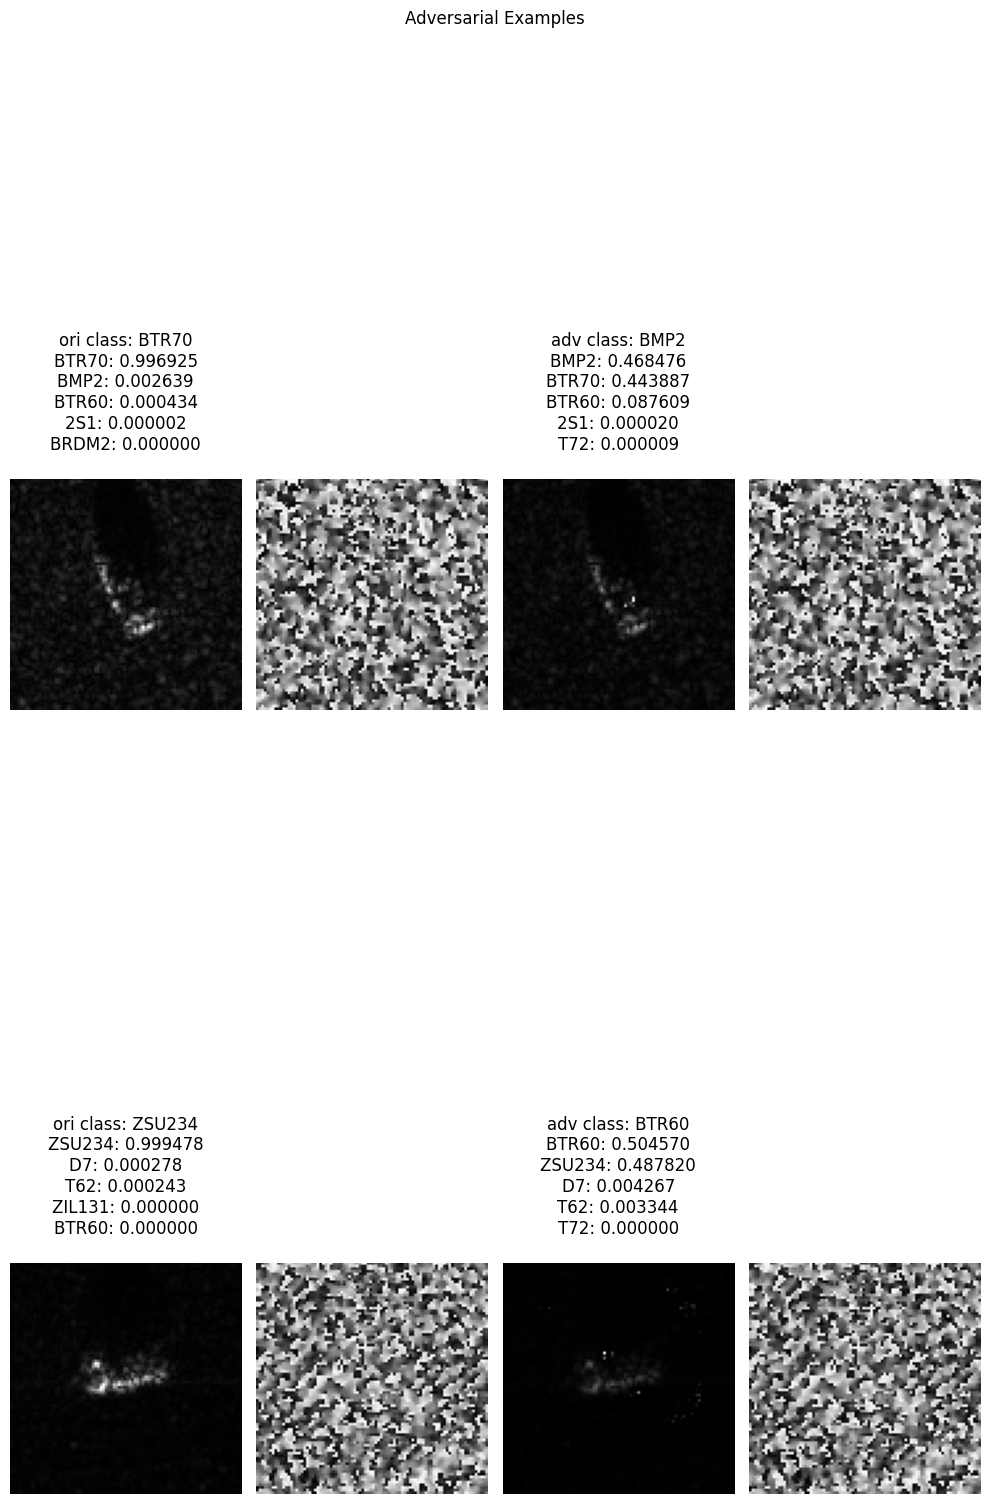

In [48]:
show_image(images, clipped, label_index,  label_index_clipped, target_name_soc, "Adversarial Examples", 13, 15, 10, 20)